In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import shutil
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks
from prophet.plot import plot_plotly, plot_components_plotly
import gc


Define Variables

In [2]:
start_date = pd.Timestamp('2024-03-22')
end_date = pd.Timestamp('2024-03-27')

Fetch data and store as dataframe (data ingestion)

The total number of duplicates is: 89496
 
Number of days data = Total records 2591984 / records per day (431998) = 5.999990740697873 
 
Head of dataframe: 
                           NS_SQUID  Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate
2024-03-22 00:00:00.200 -21.300900  -7.2962  10926.411133   -85.987000 -22660.285156
2024-03-22 00:00:00.400 -21.297199  -7.2831  10926.420898   -85.779297 -22660.291016
2024-03-22 00:00:00.600 -21.293900  -7.2878  10926.420898   -85.779297 -22660.291016
2024-03-22 00:00:00.800 -21.290400  -7.2997  10926.418945   -85.763702 -22660.292969
2024-03-22 00:00:01.000 -21.289600  -7.2765  10926.417969   -85.504799 -22660.328125


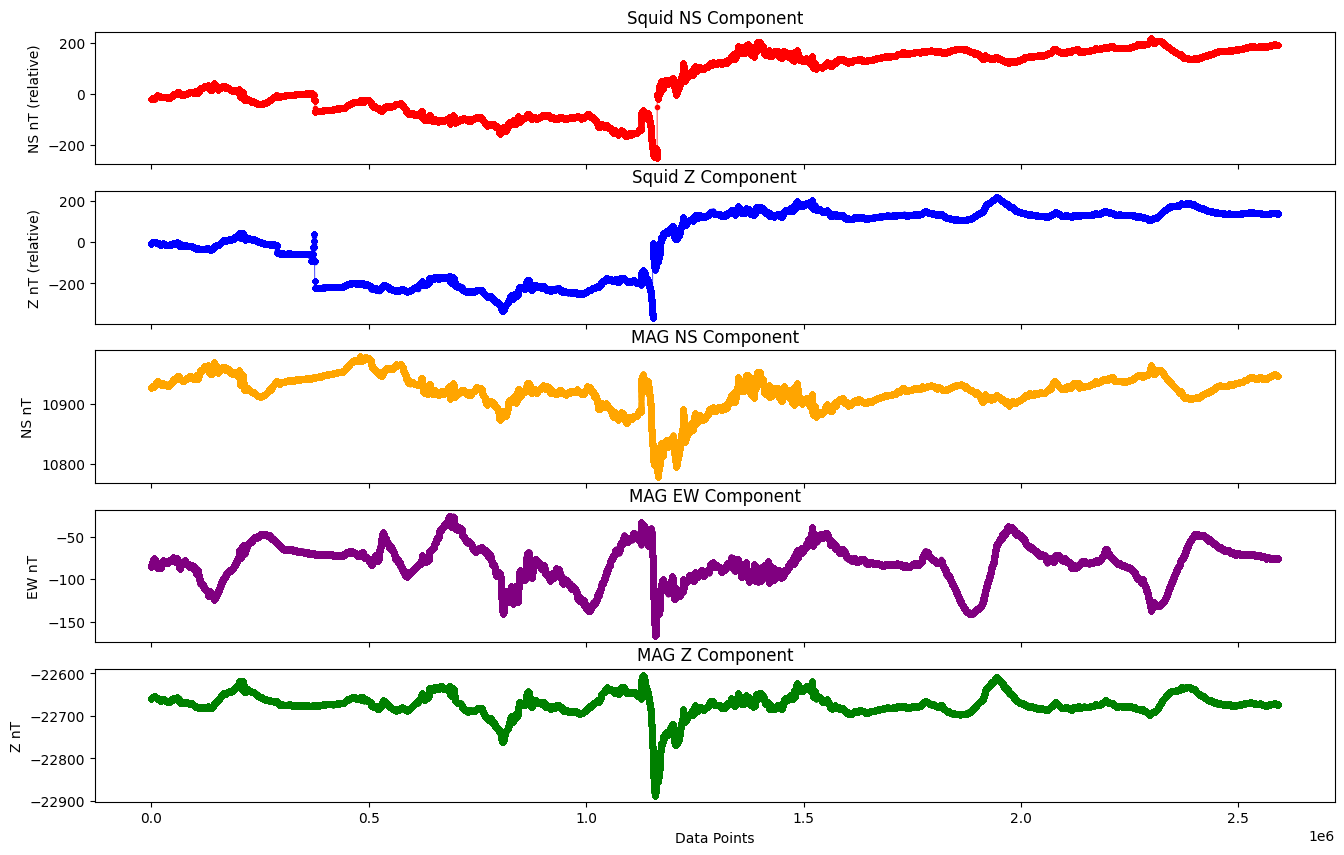

In [3]:
data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date, end_date))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date, end_date))
df = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date)
df = df.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
del data_arr_mag, data_arr_squid
gc.collect()
# df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df.shape[0]} / records per day (431998) = {df.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df.head().to_string(index=True))
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)


# Scale SQUID data

Determine the Offset (Baseline)

Define Quiet Period

In [ ]:
start_date_quiet = '2024-03-26'
end_date_quiet = '2024-03-31'

data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date_quiet, end_date_quiet))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date_quiet, end_date_quiet))
df_quiet = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date_quiet)
df_quiet = df_quiet.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
del data_arr_mag, data_arr_squid
gc.collect()
# df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df_quiet.shape[0]} / records per day (431998) = {df_quiet.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df_quiet.head().to_string(index=True))


Calculate offset

In [4]:
columns  = ["NS_SQUID","Z_SQUID"]
for column in df_quiet.columns:
    feature_mean = df_quiet[column].mean()


NameError: name 'df_quiet' is not defined

# Standardise the dataset

Using Z-Score

New head after standardize                          NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  \
2024-03-22 00:00:00.200 -0.648003 -0.086930     0.201128    -0.233356   
2024-03-22 00:00:00.400 -0.647971 -0.086848     0.201484    -0.224207   
2024-03-22 00:00:00.600 -0.647943 -0.086878     0.201484    -0.224207   
2024-03-22 00:00:00.800 -0.647913 -0.086952     0.201413    -0.223520   
2024-03-22 00:00:01.000 -0.647906 -0.086807     0.201378    -0.212114   

                         Z_Fluxgate  
2024-03-22 00:00:00.200    0.453425  
2024-03-22 00:00:00.400    0.453207  
2024-03-22 00:00:00.600    0.453207  
2024-03-22 00:00:00.800    0.453134  
2024-03-22 00:00:01.000    0.451821  


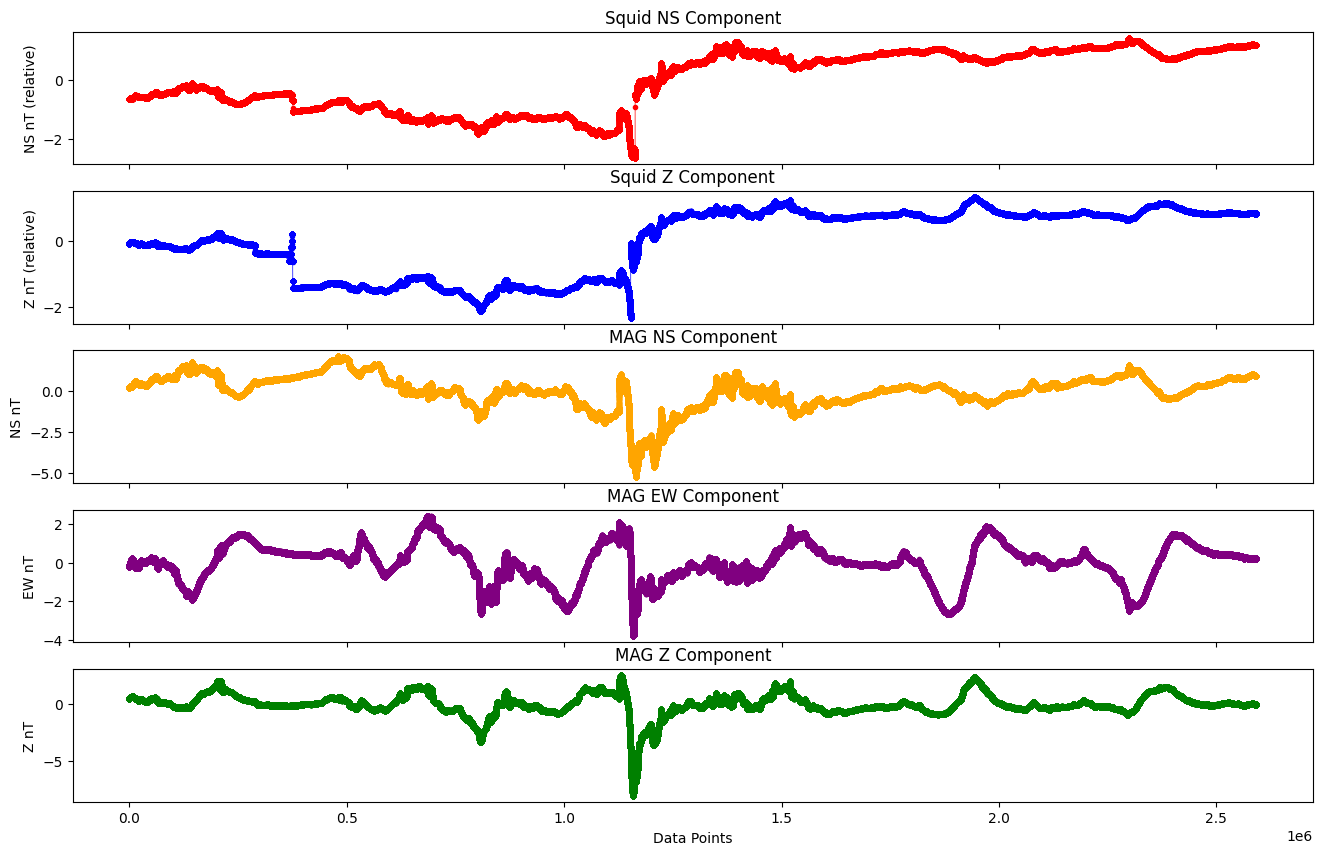

In [5]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

print(f'New head after standardize', df.head())
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)

### Check for missing values and zero values

In [6]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())


 Number of missing values in NS_SQUID is:  0
Nmber of zeros in NS_SQUID is:  0

 Number of missing values in Z_SQUID is:  0
Nmber of zeros in Z_SQUID is:  0

 Number of missing values in NS_Fluxgate is:  0
Nmber of zeros in NS_Fluxgate is:  58

 Number of missing values in EW_Fluxgate is:  0
Nmber of zeros in EW_Fluxgate is:  0

 Number of missing values in Z_Fluxgate is:  0
Nmber of zeros in Z_Fluxgate is:  189


### Outlier Test

Z score test

 
 Shape of df before removing outliers (2591984, 5)
                                Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
2024-03-22 00:00:00.200000000  0.086930     0.200874     0.233354    0.453322
2024-03-22 00:00:00.400000000  0.086849     0.201230     0.224204    0.453103
2024-03-22 00:00:00.600000000  0.086878     0.201230     0.224204    0.453103
2024-03-22 00:00:00.800000000  0.086952     0.201159     0.223517    0.453030
2024-03-22 00:00:01.000000000  0.086808     0.201123     0.212112    0.451717
...                                 ...          ...          ...         ...
2024-03-24 17:32:39.200000000  0.822447     0.904465     0.194404    0.037597
2024-03-24 17:32:39.400000000  0.822397     0.904465     0.194404    0.037597
2024-03-24 17:32:39.600000000  0.822422     0.904358     0.192342    0.037451
2024-03-24 17:32:39.800000000  0.822411     0.904465     0.191659    0.036357
2024-03-22 00:00:00.000000001  0.822410     0.904465     0.191659    0.036357

[2591984 r

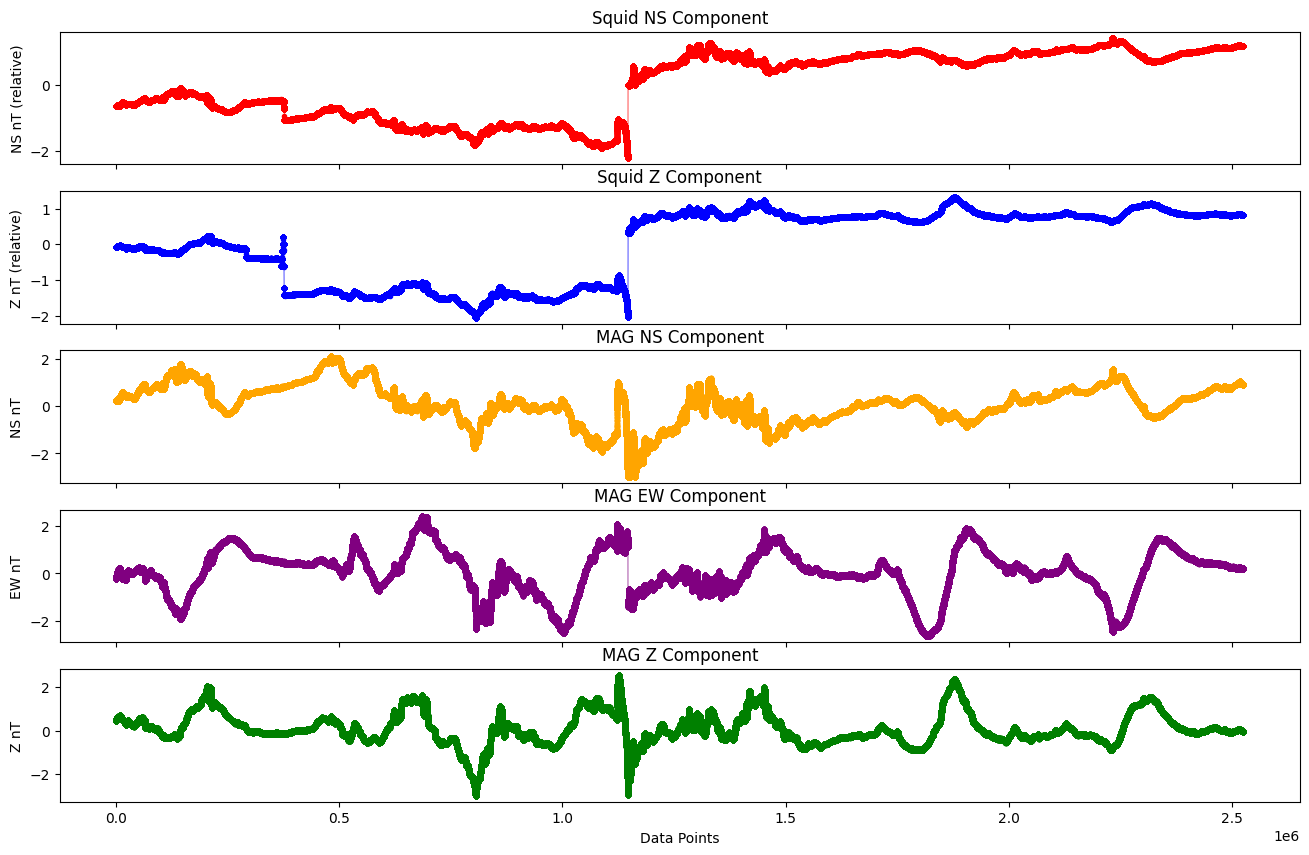

In [7]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_z = eda.z_score_test(df)
print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)
print(f'\nProportion of outliers removed:', (1-outliers_removed_z.shape[0]/df.shape[0])*100, '%')
del df
gc.collect()
eda.generateDataPlots(outliers_removed_z['NS_SQUID'].values, outliers_removed_z['Z_SQUID'].values, outliers_removed_z['NS_Fluxgate'].values, outliers_removed_z['EW_Fluxgate'].values, outliers_removed_z['Z_Fluxgate'].values, outliers_removed_z.shape[0], 431997, start_date, end_date)

### Fix sudden jumps or drops in the data

As we can see there are severe drops in the squid data. Lets fix these

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.


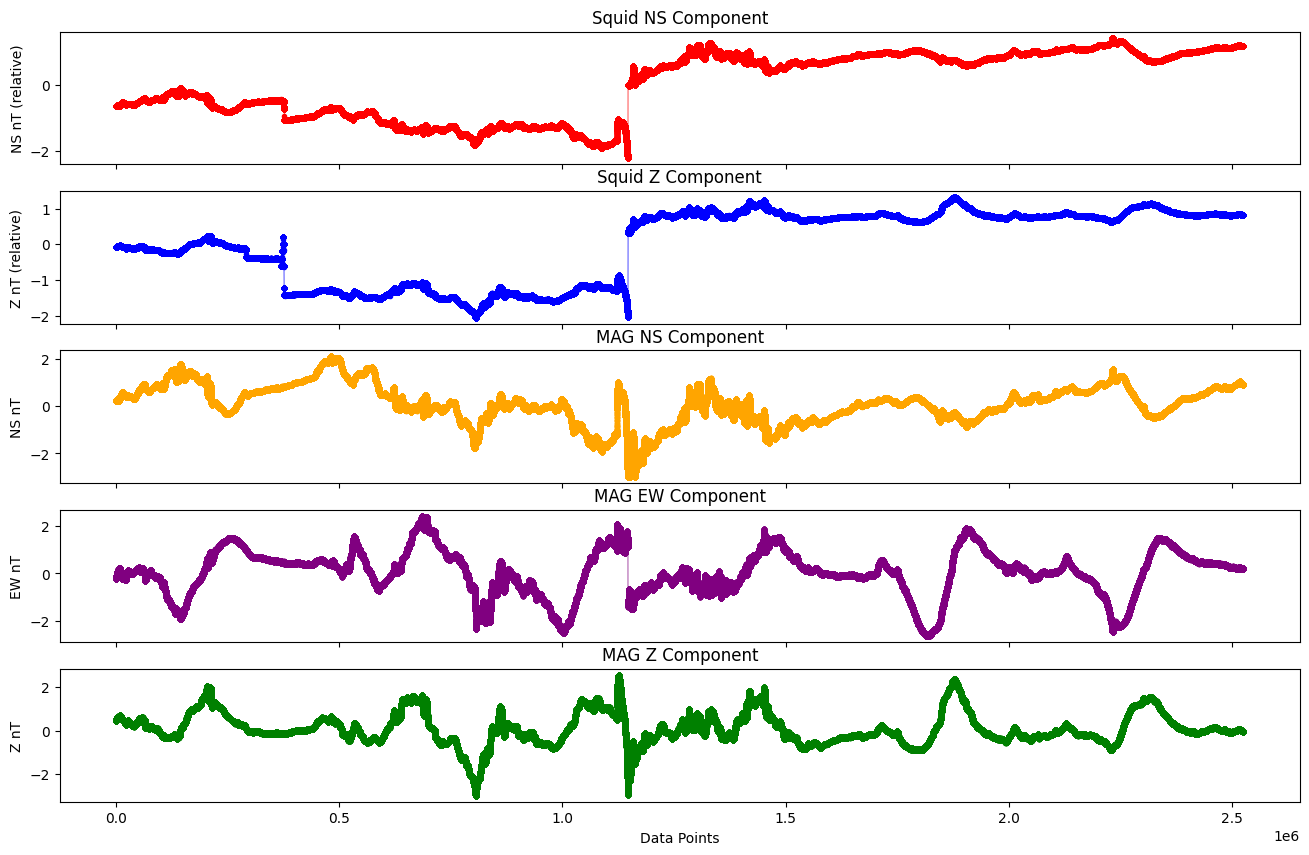

In [8]:
corrected_df_ns = eda.detect_spikes_and_correct(outliers_removed_z, "NS_SQUID")
corrected_df_f = eda.detect_spikes_and_correct(corrected_df_ns, "Z_SQUID")
corrected_df_nf = eda.detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
corrected_df_ew = eda.detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
corrected_df = eda.detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")
del outliers_removed_z, corrected_df_ns, corrected_df_f, corrected_df_nf, corrected_df_ew
gc.collect()
eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['Z_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, corrected_df.shape[0], 431997, start_date, end_date)

# Feature Generation

Now add the H component

In [9]:
h_component = np.sqrt(corrected_df['NS_Fluxgate']**2 + corrected_df['EW_Fluxgate']**2)
corrected_df.loc[:,"H Component"] = h_component
print(corrected_df)

                               NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  \
2024-03-22 00:00:00.200000000 -0.648003 -0.086930     0.201128    -0.233356   
2024-03-22 00:00:00.400000000 -0.647971 -0.086848     0.201484    -0.224207   
2024-03-22 00:00:00.600000000 -0.647943 -0.086878     0.201484    -0.224207   
2024-03-22 00:00:00.800000000 -0.647913 -0.086952     0.201413    -0.223520   
2024-03-22 00:00:01.000000000 -0.647906 -0.086807     0.201378    -0.212114   
...                                 ...       ...          ...          ...   
2024-03-24 17:32:39.200000000  1.185370  0.822447     0.904720     0.194401   
2024-03-24 17:32:39.400000000  1.185378  0.822397     0.904720     0.194401   
2024-03-24 17:32:39.600000000  1.185386  0.822422     0.904613     0.192340   
2024-03-24 17:32:39.800000000  1.185370  0.822412     0.904720     0.191657   
2024-03-22 00:00:00.000000001  1.185385  0.822411     0.904720     0.191657   

                               Z_Fluxgate  H Compon

# Now Resample

In [11]:
def resample_time_series(df, start_date, end_date):
  """Resamples time series data from 5Hz to 1 sample per minute for a given date range.

  Args:
    df: Pandas DataFrame containing the time series data.
    start_date: Start date for resampling.
    end_date: End date for resampling.

  Returns:
    Resampled Pandas DataFrame with 1 sample per minute.
  """

  # Filter data for the specified date range
  filtered_df = df[(df.index >= start_date) & (df.index < end_date)]

  # Resample to 1 minute frequency
  resampled_df = filtered_df.resample('min').mean()  # Adjust resampling method as needed

  return resampled_df

# Resample data for each day
for day in pd.date_range(start_date, end_date, freq='D'):
  resampled_data = resample_time_series(corrected_df, day, day + pd.Timedelta(days=1))
  # Do something with the resampled data, e.g., save to a file
  resampled_data.to_csv(f'/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/{day.strftime("%Y-%m-%d")}.csv')

In [ ]:
print(f' \n Shape of incoming dataframe', corrected_df.shape)
resampled_df = eda.calculate_mean_of_five(corrected_df)
print(f"Shape of new resampled dataframe is:", resampled_df.shape)
print(f"The number of records we should have is: {round(corrected_df.shape[0]/15)}")
eda.generateDataPlots(resampled_df['NS_SQUID'].values, resampled_df['Z_SQUID'].values, resampled_df['NS_Fluxgate'].values, resampled_df['EW_Fluxgate'].values, resampled_df['Z_Fluxgate'].values, resampled_df.shape[0], 86400, start_date, end_date)

Test for stationarity

In [ ]:
eda.perform_dickey_fuller_test(resampled_df)

Test for seasonality and trend

In [ ]:
eda.test_stationarity(corrected_df)

Now using the autocorrelation_plot

In [ ]:
# Draw Plot
for column in resampled_df.columns:
    plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
    autocorrelation_plot(resampled_df[column].tolist())
    plt.title(f'Autocorrelation for {column}')
    plt.show()  # Display the plot

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Create PDF of each feature

In [ ]:
import seaborn as sns

for column in resampled_df.columns:
    sns.displot(resampled_df[column], kde=True)

Perform Decomposition

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

Write the preprocessed dataframe to a file

In [ ]:
resampled_df.to_csv('/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/{}-{}.csv'.format(start_date, end_date), index=True)
